#Análisis Central Telefónica Zohoo-ANURA

### Librerías utilizadas

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis Exploratorio de Datos (AED)


---



In [61]:
# Cargo el DataSet original exportado desde la central telefónica
# verifico la dimensión del DS original

df = pd.read_csv('cdrs_new.csv', sep=',' , encoding='unicode_escape')  # encoding='latin-1'    'unicode_escape'
df.shape


(84095, 22)

In [62]:
# No es necesario ejecutarlo ya que una vez que lo trabajamos debería NO cambiar.
# Considerar si se presenta un error en la depuración que viene después
df.head(5)

,Fecha,DirecciÃ³n,Nro. Origen,Origen,Nro. Destino,Destino,Estado,DuraciÃ³n total,DuraciÃ³n conversaciÃ³n,Tiempo espera,...,Cola nombre,Cola estado,Cola duraciÃ³n total,Cola duraciÃ³n conversaciÃ³n,Cola tiempo espera,Cola agente,Cola terminal agente,Cuenta contestÃ³,Terminal contestÃ³,Departamento
0,2021-05-26 17:31:09.17,IN,1154838143,Argentina/AMBA - MOVIL,116,Soporte,ANSWER,12,4,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dellia Arguello,softphone-107,Mesa de Soporte
1,2021-05-27 11:49:21.764,IN,3434281165,Argentina/PARANA - MOVIL,116,Soporte,ANSWER,51,22,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
2,2021-05-27 11:50:13.19,OUT,3434281165,NaN,116,Soporte,ANSWER,33,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mesa de Soporte
3,2021-05-27 11:50:13.27,IN,3434281165,Argentina/PARANA - MOVIL,116,Soporte,ANSWER,33,23,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carlos GarcÃ­a,softphone-109,Mesa de Soporte
4,2021-05-27 19:52:18.187,IN,1154838143,Argentina/AMBA - MOVIL,116,Soporte,ANSWER,60,51,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Micaela Jotter,softphone-106,Mesa de Soporte


In [63]:
df.dtypes # Campos y sus tipos

Fecha                            object
DirecciÃ³n                       object
Nro. Origen                       int64
Origen                           object
Nro. Destino                     object
Destino                          object
Estado                           object
DuraciÃ³n total                   int64
DuraciÃ³n conversaciÃ³n           int64
Tiempo espera                     int64
Precio                          float64
Ultima acciÃ³n                   object
Cola nombre                     float64
Cola estado                     float64
Cola duraciÃ³n total            float64
Cola duraciÃ³n conversaciÃ³n    float64
Cola tiempo espera              float64
Cola agente                     float64
Cola terminal agente            float64
Cuenta contestÃ³                 object
Terminal contestÃ³               object
Departamento                     object
dtype: object

#**Depuración del dataset cdrs.csv**


---

- "Fecha" separar en "Fecha" y "Hora"
- "Origen" --> separar Argentina/SAN NICOLAS - MOVIL
- **NUEVO** "Direccion" --> analizaremos IN.
- "Cuenta contestÃ³" reemplazaremos las NaN por "Perdidas" luego reemplazaremos el nombre de la etiqueta por CuentaContesto.
- ***Generar:***
- "FranjaHoraria" --> valores desde 8 a 19 indican la hora que cubre la Mesa de Ayuda.
- "Turno" --> toma el valor **1** (mañana 8 a 13:59) y **2** (tarde 14 a 19)
- "Turno-Tel" --> toma el valor **1** (mañana 8 a 17:00) y **2** (tarde 17:01 a 20)
- "Turno-Tel_2" --> toma el valor **1** (mañana 8 a 12:00) y **2** (tarde 12:01 a 20)  --  **"NUEVO"**
- "DiaSemana"  --> lunes, martes, miércoles, jueves, viernes, sábado
- "Provincia" --> generar las Provincias de Argentina
- "Region" --> Dividimos el país en Regiones sur, norte, centro, buenos aires y cuyo.
- ***Eliminar:***
- "Nro. Destino"
- "Destino"
- "Estado"
- "Precio"
- "Ultima acción"
- "Cola nombre"
- "Cola estado"
- "Cola duración total"
- "Cola duración conversación"
- "Cola tiempo espera"
- "Cola agente"
- "Cola terminal agente"
- "Departamento"

In [64]:
# Separar el campo "Fecha" en --> "Fecha" y "Hora"
# Eliminar el campo 'Fecha ' ojo que quedará el generado 'Fecha'
# Generamos el campo "FranjaHoraria" tomando sólo la hora. --> valores desde 8 a 19 horario que cubre la Mesa de Ayuda.
# comenzamos a modelar el df (es el que vamos a utilizar para trabajar en lo análisis finales)

df['Fecha'] = pd.to_datetime(df['Fecha ']).dt.date
df['Hora'] = pd.to_datetime(df['Fecha ']).dt.time
df['FranjaHoraria'] = pd.to_datetime(df['Fecha ']).dt.hour

"""
df = df.drop(df[df['FranjaHoraria'] == 7].index)  # Eliminar filas donde 'FranjaHoraria' cumple una condición específica
df = df.drop(df[df['FranjaHoraria'] == 21].index)  # Eliminar filas donde 'FranjaHoraria' cumple una condición específica
df = df.drop(df[df['FranjaHoraria'] == 22].index)  # Eliminar filas donde 'FranjaHoraria' cumple una condición específica
"""

df = df.drop(['Fecha '], axis='columns')


# "Origen" --> separar Argentina/SAN NICOLAS - MOVIL
# Esto por el momento no sé si tiene sentido hacerlo, lo dejaríamos para analizar luego


# "Direccion" --> Incorporamos además de los IN los OUT también para analizar la disponibilidad de los recursos que atienden.
# Es importante porque se perdía la disponibilidad del agente viendo solamente la atención de entradas "IN"
# Luego de filtrarlos; elimino la columna 'DirecciÃ³n '
""" ---------- Sacamos todo este código ----------"""
"""df = df[df['DirecciÃ³n '] == 'IN']"""
"""df = df[(df['DirecciÃ³n '] == 'IN') | (df['DirecciÃ³n '] == 'OUT')]
df = df.drop(['DirecciÃ³n '], axis='columns')"""

# Para poder trabajar las "Llamadas perdidas" reemplazaremos los valores nulos (NaN) de CuentaContesto a "PerdidasAnura"
df['Cuenta contestÃ³'].fillna('PerdidasAnura', inplace=True)

# "Nro. Origen" sacamos los valores 0, 112, 900
# Son internos que no vamos a considerar en los análisis
df = df[df['Nro. Origen '] != 0 ]   #  and df['Nro. Origen '] != 112 and df['Nro. Origen '] != 900]
df = df[df['Nro. Origen '] != 112 ]
df = df[df['Nro. Origen '] != 900 ]


# Generamos un nuevo campo "Turno" con los valores:
#    1 --> para los valores entre 8 y 13hs.
#    2 --> para los valores entre 14 y 20hs.
df['Turno'] = [1 if ( s>=8 and s<14) else 2 for s in df['FranjaHoraria']]

# Generamos un nuevo campo "Turno-Tel" con los valores:
#    1 --> para los valores entre 8 y 15:59hs.
#    2 --> para los valores entre 16 y 20hs.
df['Turno-Tel'] = [1 if ( s>=8 and s<17) else 2 for s in df['FranjaHoraria']]

df['Turno-Tel_2'] = [1 if ( s>=8 and s<12) else 2 for s in df['FranjaHoraria']]


# Generamos "DiaSemana" --> lunes, martes, miércoles, jueves, viernes, sábado
df['Fecha'] = pd.to_datetime(df['Fecha']) # convertimos la columna Fecha en datetime para poder calcular el día de la semana
df['DiaSemana'] = df['Fecha'].dt.day_name()

# Generar "Provincia" --> generar las Provincias de Argentina


# Generar "Region" --> Dividimos el país en Regiones sur, norte, centro, buenos aires y cuyo.


# Eliminación de las columnas que NO utizamos
df = df.drop(['Nro. Destino ','Destino ','Estado ', 'Precio','Ultima acciÃ³n','Cola nombre', 'Cola estado','Cola duraciÃ³n total','Cola duraciÃ³n conversaciÃ³n','Cola tiempo espera','Cola agente','Cola terminal agente','Departamento'], axis='columns')
df.shape


# Cambiamos los nombres de las columnas DirecciÃ³n , DuraciÃ³n total y  DuraciÃ³n conversaciÃ³n
df.columns.values[0] = "Direccion"
df.columns.values[3] = "DuracionT"
df.columns.values[4] = "DuracionConv"
df.columns.values[6] = "CuentaContesto"
df.columns.values[7] = "TerminalContesto"


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19568\2953115760.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cuenta contestÃ³'].fillna('PerdidasAnura', inplace=True)


In [65]:
df.head(5)


,Direccion,Nro. Origen,Origen,DuracionT,DuracionConv,Tiempo espera,CuentaContesto,TerminalContesto,Fecha,Hora,FranjaHoraria,Turno,Turno-Tel,Turno-Tel_2,DiaSemana
0,IN,1154838143,Argentina/AMBA - MOVIL,12,4,8,Dellia Arguello,softphone-107,2021-05-26,17:31:09.170000,17,2,2,2,Wednesday
1,IN,3434281165,Argentina/PARANA - MOVIL,51,22,29,PerdidasAnura,NaN,2021-05-27,11:49:21.764000,11,1,1,1,Thursday
2,OUT,3434281165,NaN,33,23,10,PerdidasAnura,NaN,2021-05-27,11:50:13.190000,11,1,1,1,Thursday
3,IN,3434281165,Argentina/PARANA - MOVIL,33,23,10,Carlos GarcÃ­a,softphone-109,2021-05-27,11:50:13.270000,11,1,1,1,Thursday
4,IN,1154838143,Argentina/AMBA - MOVIL,60,51,9,Micaela Jotter,softphone-106,2021-05-27,19:52:18.187000,19,2,2,2,Thursday


In [66]:
# Genero un archivo csv para trabajarlo con una herramienta para Dashboard.
df.to_csv('call_center.csv', index=False)

# Filtros por fecha considerando lo que quiero analizar.
## Sólo ejecutar si queremos trabajar un Rango de fecha diferente

SI queremos ***analizar el histórico***, ***NO corremos estas líneas*** usamos el df como viene desde el inicio.

# ⭐ INFORMES FINALES

---


# ⏰ Rango de fechas del "DS"

In [67]:
# Tomo las fechas de inicio y fecha final para poder establecer los rangos y maquetarlos en las gráficas.
fecha_minima = df['Fecha'].min().strftime('%Y-%m-%d')  # utilizamos strftime('%Y-%m-%d') para quitar la hora que me muestra.
fecha_maxima = df['Fecha'].max().strftime('%Y-%m-%d')  # idem
print("El rango de fechas es desde: \n {} hasta {}".format(fecha_minima, fecha_maxima))

El rango de fechas es desde: 
 2021-05-26 hasta 2024-10-28


## **Cantidad** de llamadas entrantes "**IN**".
(por franja horaria)

* He definido 3 umbrales (thresholds) y
* 3 colores correspondientes (color_palette).
* **Rojo** picos de llamadas se necesitan 4 recursos al teléfono.
* **Amarillo** intermedios.
* **Verde** picos bajos de llamadas. :

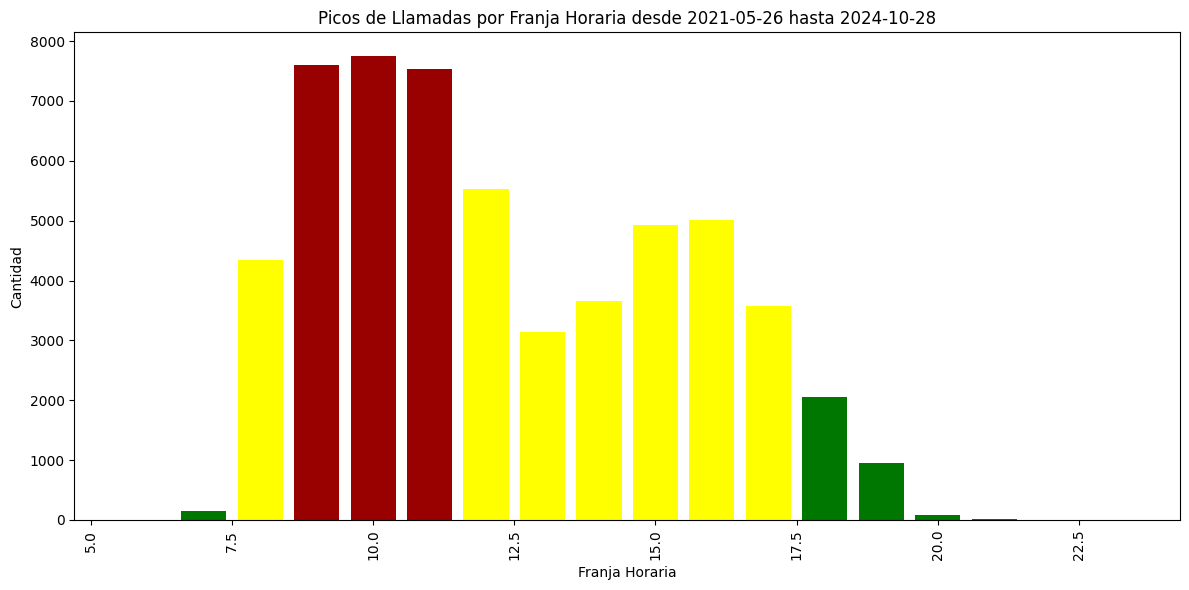

In [68]:
# Filtrar los registros donde la dirección sea "IN" / "OUT"
df = df[df['Direccion'] == 'IN']
"""df_in = df[df['Direccion'] == 'IN']
df_out = df[df['Direccion'] == 'OUT']"""

# Obtener los datos de conteo y ordenarlos
"""counts = df_in['FranjaHoraria'].value_counts().sort_index()"""
counts = df['FranjaHoraria'].value_counts().sort_index()

# Definir los colores para el mapa de calor
colors = np.array(['#ECECEC'] * len(counts))

# Calcular los umbrales en función de los porcentajes
percentage_thresholds = [40, 75, 100]  # Porcentajes para los umbrales

# Calcular los umbrales basados en los porcentajes
max_count = counts.max()
thresholds = [max_count * (p / 100) for p in percentage_thresholds]

# Definir los colores correspondientes
color_palette = ['#007700', '#FFFF00', '#990000']  # Verde, Amarillo, Rojo FF0000

# Asignar colores diferentes a los rangos de valores
for i in range(len(thresholds)):
    if i == 0:
        colors[counts <= thresholds[i]] = color_palette[i]
    else:
        colors[(counts > thresholds[i-1]) & (counts <= thresholds[i])] = color_palette[i]

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))  # Ajusta el tamaño de acuerdo a tus preferencias

# Reducir el tamaño de la fuente de las etiquetas del eje x
plt.xticks(fontsize=10, rotation=90)

# Crear el gráfico de barras con colores
plt.bar(counts.index, counts.values, color=colors)

# Personalizar las etiquetas y el título
plt.xlabel('Franja Horaria')
plt.ylabel('Cantidad')
plt.title(f'Picos de Llamadas por Franja Horaria desde {fecha_minima} hasta {fecha_maxima}')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el espaciado
plt.show()

## Duración de la llamadas según Franja Horaria.

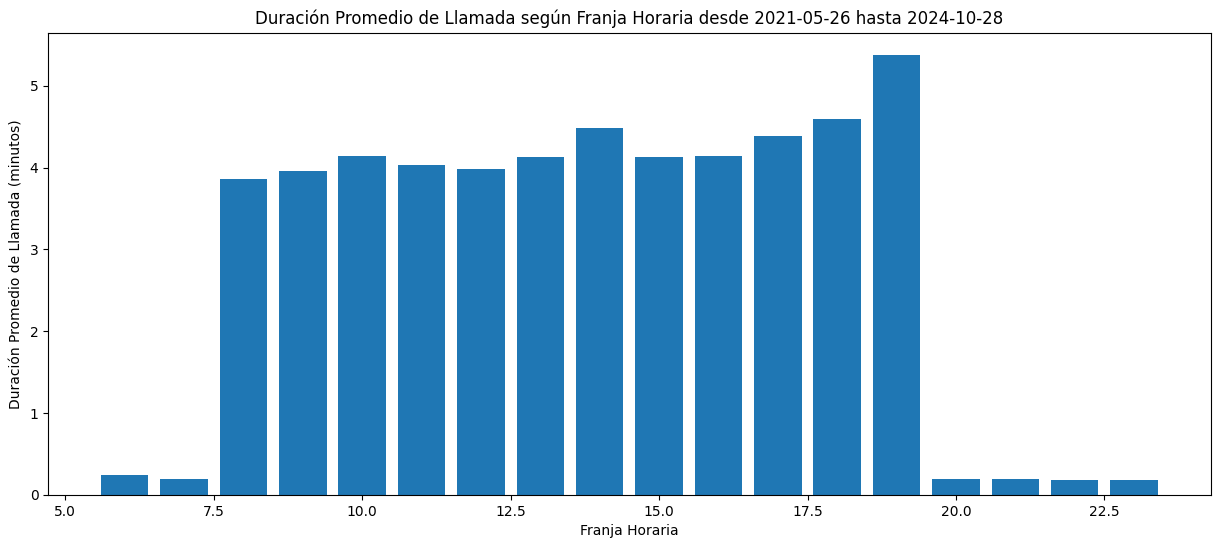

In [69]:
# Nos interesa saber si la duracion de la llamada varia segun el momento del dia

# Agrupar y calcular la duración promedio de las llamadas por franja horaria se agregó la posibilidad de visualizar
#  3 opciones histórico, por Mes o por Dia.
duration_by_hour = df.groupby('FranjaHoraria')['DuracionT'].mean()

# Convertir los valores de duración de segundos a minutos
duration_by_hour = duration_by_hour / 60

# Ordenar los valores por franja horaria
duration_by_hour = duration_by_hour.sort_index()

# Ajustar el tamaño de la figura
plt.figure(figsize=(15, 6))  # Ajusta el tamaño de acuerdo a tus preferencias

# Crear el gráfico de barras
plt.bar(duration_by_hour.index, duration_by_hour.values)


# Personalizar las etiquetas y el título
plt.xlabel('Franja Horaria')
plt.ylabel('Duración Promedio de Llamada (minutos)')
plt.title(f'Duración Promedio de Llamada según Franja Horaria desde {fecha_minima} hasta {fecha_maxima}')

# Mostrar el gráfico
plt.show()

## Duración de la llamada de acuerdo al usuario

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19568\4000031727.py:23: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Ajustar el espaciado
d:\Desarrollo\Proyectos\Proyectos-publicos\Soporte Call Center\.env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


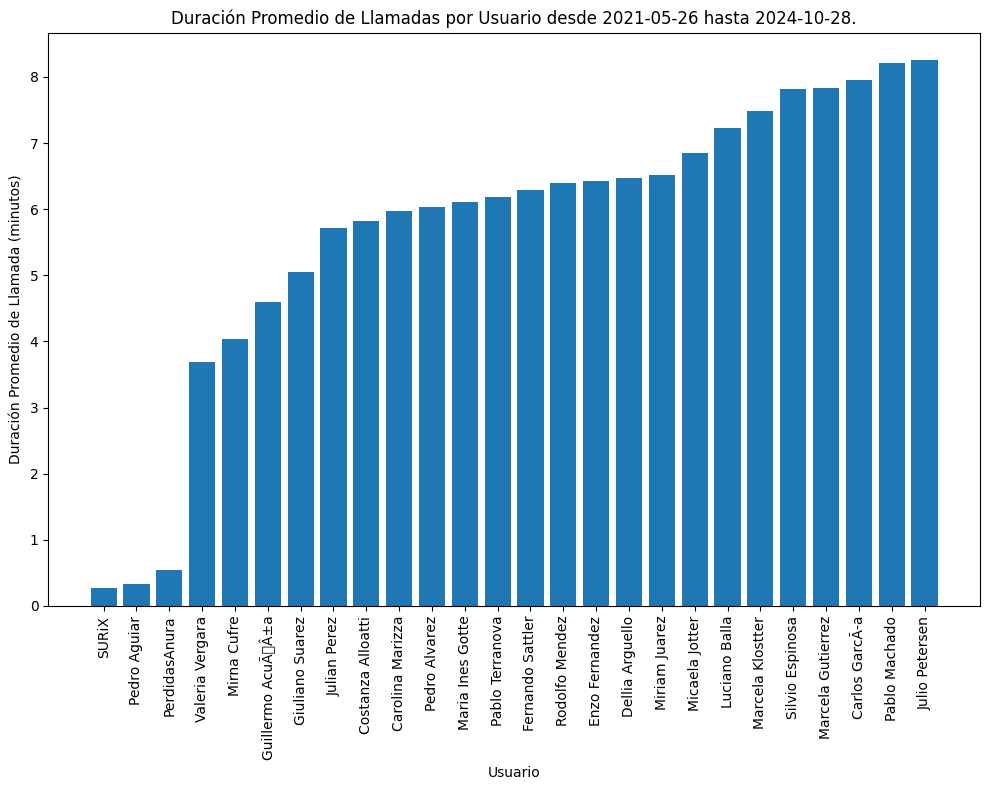

In [70]:
# Agrupar y calcular la duración promedio de las llamadas por usuario
duration_by_user = df.groupby('CuentaContesto')['DuracionT'].mean() # el dataframe df no descrimina IN y OUT.

# Convertir los valores de duración de segundos a minutos
duration_by_user = duration_by_user / 60

# Ordenar los valores por duración promedio
duration_by_user = duration_by_user.sort_values()

# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de acuerdo a tus preferencias

# Crear el gráfico de barras
plt.bar(duration_by_user.index, duration_by_user.values)

# Personalizar las etiquetas y el título
plt.xlabel('Usuario')
plt.ylabel('Duración Promedio de Llamada (minutos)')
plt.title(f'Duración Promedio de Llamadas por Usuario desde {fecha_minima} hasta {fecha_maxima}.')

# Mostrar el gráfico
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para mayor legibilidad
plt.tight_layout()  # Ajustar el espaciado
plt.show()

## Gráfico Boxplot tiempos en llamadas.

* Gráfico de caja y bigotes de la duración de las llamadas por usuario.
* Cada caja representa el rango intercuartil (IQR), donde la línea central es la mediana, el borde inferior de la caja es el primer cuartil (Q1), el borde superior es el tercer cuartil (Q3) y los bigotes indican el rango de valores típicos.
* Los puntos más allá de los bigotes se consideran outliers.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_19568\820560099.py:22: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2400x1500 with 0 Axes>

d:\Desarrollo\Proyectos\Proyectos-publicos\Soporte Call Center\.env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 131 (\x83) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


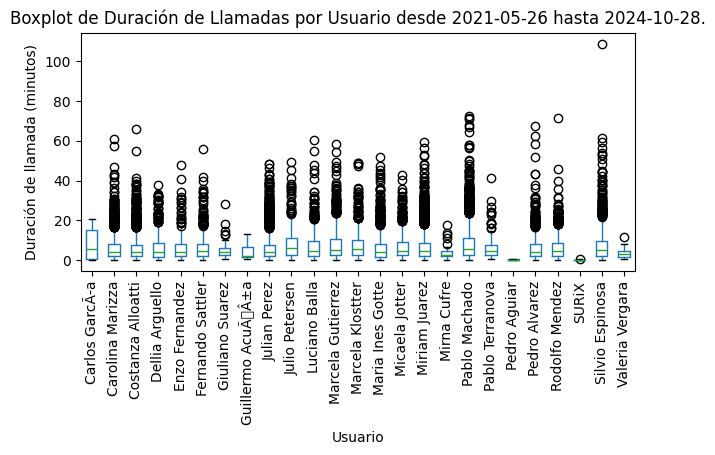

In [71]:

# Convertir la duración de la llamada a minutos
df['DuracionMin'] = df['DuracionT'] / 60
df = df[df['CuentaContesto'] != 'PerdidasAnura']  # quitamos los registros etiquetados como perdidas Anura ya que no valen la pena trabajarlos.

# Graficar boxplot de duración por usuario
plt.figure(figsize=(24, 15))  # Ajustar tamaño de la figura según tus preferencias

df.boxplot(column='DuracionMin', by='CuentaContesto')

plt.xlabel('Usuario')
plt.ylabel('Duración de llamada (minutos)')
plt.title(f'Boxplot de Duración de Llamadas por Usuario desde {fecha_minima} hasta {fecha_maxima}.')
plt.suptitle('')  # Eliminar título automático generado por Pandas

# Rotar las etiquetas del eje X a 90 grados
plt.xticks(rotation=90)

# Desactivar las grillas en el gráfico
plt.grid(False)

# Ajustar el espacio entre los subplots
plt.tight_layout()

plt.show()
